# Chapter 2 - Multi-armed bandits

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from tqdm import trange

%matplotlib inline
# matplotlib.use('Agg')



class Bandit:
    # @k_arm: # of arms
    # @epsilon: probability for exploration in epsilon-greedy algorithm
    # @initial: initial estimation for each action
    # @step_size: constant step size for updating estimations
    # @sample_averages: if True, use sample averages to update estimations instead of constant step size
    # @UCB_param: if not None, use UCB algorithm to select action
    # @gradient: if True, use gradient based bandit algorithm
    # @gradient_baseline: if True, use average reward as baseline for gradient based bandit algorithm
    # @stationary: if True, at each step, the q_value changes
    def __init__(self, k_arm=10, epsilon=0., initial=0., step_size=0.1, sample_averages=False, UCB_param=None,
                 gradient=False, gradient_baseline=False, true_reward=0., stationary=True):
        self.k = k_arm
        self.step_size = step_size
        self.sample_averages = sample_averages
        self.indices = np.arange(self.k)
        self.time = 0
        self.UCB_param = UCB_param
        self.gradient = gradient
        self.gradient_baseline = gradient_baseline
        self.average_reward = 0
        self.true_reward = true_reward
        self.epsilon = epsilon
        self.initial = initial
        self.stationary = stationary

    def reset(self):
        # real reward for each action
        self.q_true = np.random.randn(self.k) + self.true_reward

        # estimation for each action
        self.q_estimation = np.zeros(self.k) + self.initial

        # # of chosen times for each action
        self.action_count = np.zeros(self.k)

        self.best_action = np.argmax(self.q_true)

        self.time = 0

    # get an action for this bandit
    def act(self):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.indices)

        if self.UCB_param is not None:
            UCB_estimation = self.q_estimation + \
                self.UCB_param * np.sqrt(np.log(self.time + 1) / (self.action_count + 1e-5))
            q_best = np.max(UCB_estimation)
            return np.random.choice(np.where(UCB_estimation == q_best)[0])

        if self.gradient:
            exp_est = np.exp(self.q_estimation)
            self.action_prob = exp_est / np.sum(exp_est)
            return np.random.choice(self.indices, p=self.action_prob)

        q_best = np.max(self.q_estimation)
        return np.random.choice(np.where(self.q_estimation == q_best)[0])

    # take an action, update estimation for this action
    def step(self, action):
        # generate the reward under N(real reward, 1)
        reward = np.random.randn() + self.q_true[action]
        self.time += 1
        self.action_count[action] += 1
        self.average_reward += (reward - self.average_reward) / self.time

        # add a normally distributed increment with mean zero 
        # and standard deviation 0.01 to all the q(a) on each step
        if not self.stationary:
            self.q_true += 0.01 * np.random.randn(self.k)
            self.best_action = np.argmax(self.q_true)
        
        if self.sample_averages:
            # update estimation using sample averages
            self.q_estimation[action] += (reward - self.q_estimation[action]) / self.action_count[action]
        elif self.gradient:
            one_hot = np.zeros(self.k)
            one_hot[action] = 1
            if self.gradient_baseline:
                baseline = self.average_reward
            else:
                baseline = 0
            self.q_estimation += self.step_size * (reward - baseline) * (one_hot - self.action_prob)
        else:
            # update estimation with constant step size
            self.q_estimation[action] += self.step_size * (reward - self.q_estimation[action])
        return reward
    
def simulate(runs, time, bandits):
    rewards = np.zeros((len(bandits), runs, time))
    best_action_counts = np.zeros(rewards.shape)
    for i, bandit in enumerate(bandits):
        for r in trange(runs):
            bandit.reset()
            for t in range(time):
                action = bandit.act()
                reward = bandit.step(action)
                rewards[i, r, t] = reward
                if action == bandit.best_action:
                    best_action_counts[i, r, t] = 1
    mean_best_action_counts = best_action_counts.mean(axis=1)
    mean_rewards = rewards.mean(axis=1)
    return mean_best_action_counts, mean_rewards

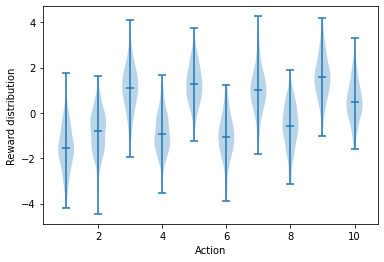

In [2]:
# Figure 2.1

plt.violinplot(dataset=np.random.randn(200, 10) + np.random.randn(10), showmeans=True)
plt.xlabel("Action")
plt.ylabel("Reward distribution")
plt.show()
plt.close()

100%|██████████| 2000/2000 [00:52<00:00, 37.95it/s]


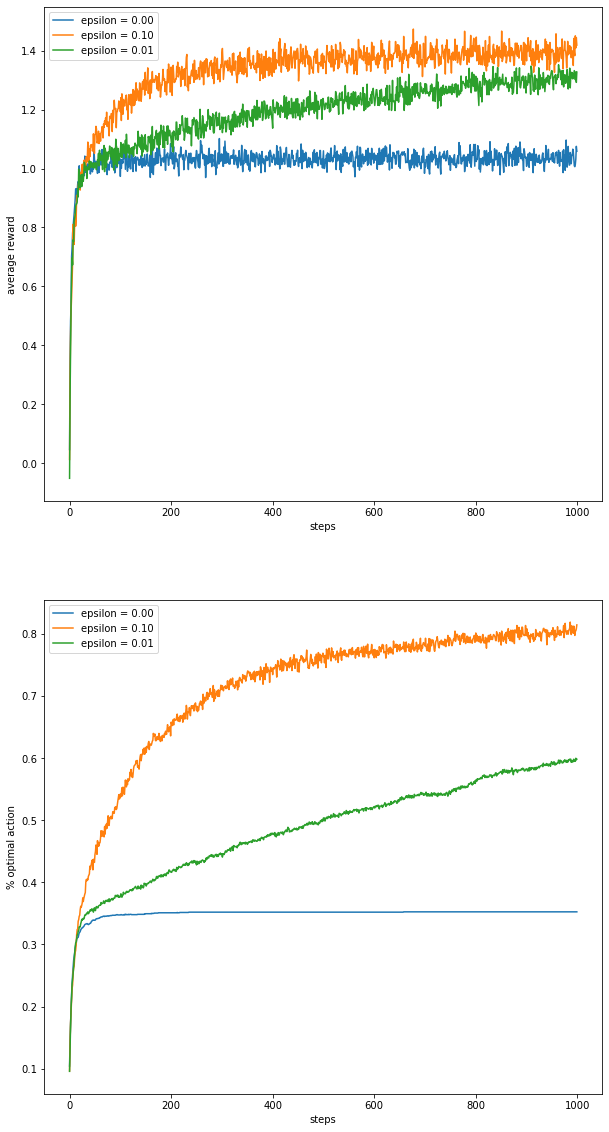

In [3]:
# Figure 2.2

runs=2000
time=1000

epsilons = [0, 0.1, 0.01]
bandits = [Bandit(epsilon=eps, sample_averages=True) for eps in epsilons]
best_action_counts, rewards = simulate(runs, time, bandits)

plt.figure(figsize=(10, 20))

plt.subplot(2, 1, 1)
for eps, rewards in zip(epsilons, rewards):
    plt.plot(rewards, label='epsilon = %.02f' % (eps))
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(2, 1, 2)
for eps, counts in zip(epsilons, best_action_counts):
    plt.plot(counts, label='epsilon = %.02f' % (eps))
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

plt.show()
plt.close()

100%|██████████| 2000/2000 [11:33<00:00,  2.88it/s]


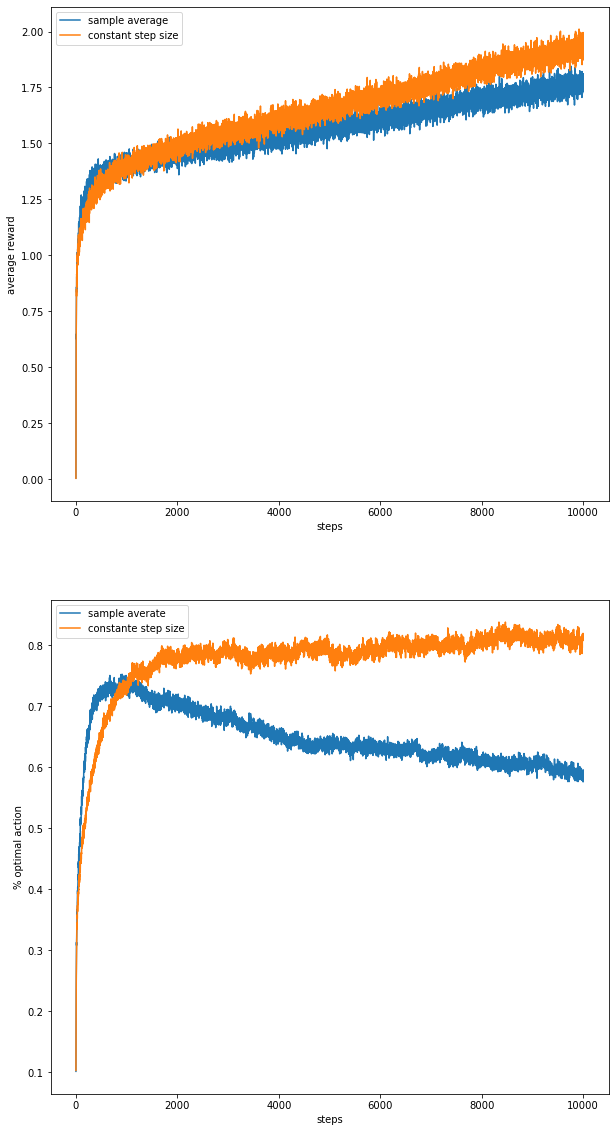

In [4]:
# Exercise 2.5

runs=2000
time=10000

epsilon = 0.1
alpha = 0.1

bandits = []

bandits.append(Bandit(epsilon=epsilon, sample_averages=True, stationary=False))
bandits.append(Bandit(epsilon=epsilon, step_size=alpha, stationary=False))

best_action_counts, rewards = simulate(runs, time, bandits)

plt.figure(figsize=(10, 20))

plt.subplot(2, 1, 1)

plt.plot(rewards[0], label='sample average')
plt.plot(rewards[1], label='constant step size')
plt.xlabel('steps')
plt.ylabel('average reward')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(best_action_counts[0], label='sample averate')
plt.plot(best_action_counts[1], label='constante step size')
plt.xlabel('steps')
plt.ylabel('% optimal action')
plt.legend()

plt.show()
plt.close()

100%|██████████| 2000/2000 [00:44<00:00, 45.39it/s]


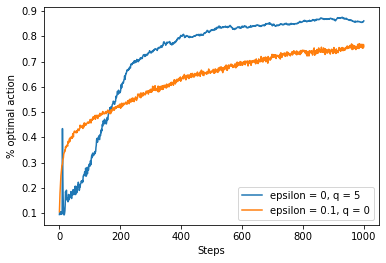

In [5]:
# Figure 2.3

runs=2000
time=1000

bandits = []
bandits.append(Bandit(epsilon=0, initial=5, step_size=0.1))
bandits.append(Bandit(epsilon=0.1, initial=0, step_size=0.1))
best_action_counts, _ = simulate(runs, time, bandits)

plt.plot(best_action_counts[0], label='epsilon = 0, q = 5')
plt.plot(best_action_counts[1], label='epsilon = 0.1, q = 0')
plt.xlabel('Steps')
plt.ylabel('% optimal action')
plt.legend()

plt.show()
plt.close()

100%|██████████| 2000/2000 [01:07<00:00, 29.79it/s]


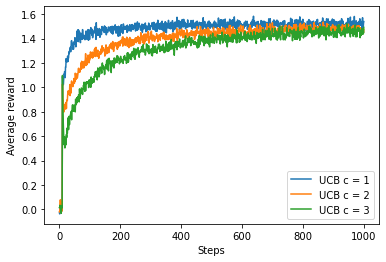

In [6]:
# Figure 2.4

runs=2000
time=1000

bandits = []
bandits.append(Bandit(epsilon=0, UCB_param=1, sample_averages=True))
bandits.append(Bandit(epsilon=0, UCB_param=2, sample_averages=True))
bandits.append(Bandit(epsilon=0, UCB_param=3, sample_averages=True))
_, average_rewards = simulate(runs, time, bandits)

plt.plot(average_rewards[0], label='UCB c = 1')
plt.plot(average_rewards[1], label='UCB c = 2')
plt.plot(average_rewards[2], label='UCB c = 3')
plt.xlabel('Steps')
plt.ylabel('Average reward')
plt.legend()

plt.show()
plt.close()

100%|██████████| 2000/2000 [01:41<00:00, 19.62it/s]


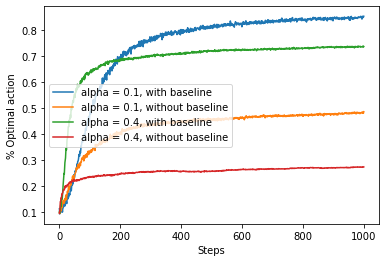

In [7]:
# Figure 2.5

runs=2000
time=1000

bandits = []
bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=True, true_reward=4))
bandits.append(Bandit(gradient=True, step_size=0.1, gradient_baseline=False, true_reward=4))
bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=True, true_reward=4))
bandits.append(Bandit(gradient=True, step_size=0.4, gradient_baseline=False, true_reward=4))
best_action_counts, _ = simulate(runs, time, bandits)
labels = ['alpha = 0.1, with baseline',
          'alpha = 0.1, without baseline',
          'alpha = 0.4, with baseline',
          'alpha = 0.4, without baseline']

for i in range(len(bandits)):
    plt.plot(best_action_counts[i], label=labels[i])
plt.xlabel('Steps')
plt.ylabel('% Optimal action')
plt.legend()

plt.show()
plt.close()

100%|██████████| 2000/2000 [01:01<00:00, 32.43it/s]


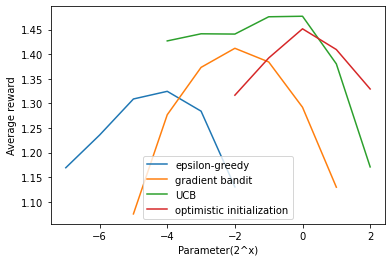

In [8]:
# Figure 2.6

runs=2000
time=1000

labels = ['epsilon-greedy', 'gradient bandit',
          'UCB', 'optimistic initialization']
generators = [lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True),
              lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True),
              lambda coef: Bandit(epsilon=0, UCB_param=coef, sample_averages=True),
              lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1)]
parameters = [np.arange(-7, -1, dtype=np.float),
              np.arange(-5, 2, dtype=np.float),
              np.arange(-4, 3, dtype=np.float),
              np.arange(-2, 3, dtype=np.float)]

bandits = []
for generator, parameter in zip(generators, parameters):
    for param in parameter:
        bandits.append(generator(pow(2, param)))

_, average_rewards = simulate(runs, time, bandits)
rewards = np.mean(average_rewards, axis=1)

i = 0
for label, parameter in zip(labels, parameters):
    l = len(parameter)
    plt.plot(parameter, rewards[i:i+l], label=label)
    i += l
plt.xlabel('Parameter(2^x)')
plt.ylabel('Average reward')
plt.legend()

plt.show()
plt.close()

In [9]:
# Exercise 2.11

runs=2000
time= 20000

labels = ['epsilon-greedy', 'gradient bandit',
          'UCB', 'optimistic initialization']
generators = [lambda epsilon: Bandit(epsilon=epsilon, sample_averages=True, stationary=False),
              lambda alpha: Bandit(gradient=True, step_size=alpha, gradient_baseline=True, stationary=False),
              lambda coef: Bandit(epsilon=0, UCB_param=coef, sample_averages=True, stationary=False),
              lambda initial: Bandit(epsilon=0, initial=initial, step_size=0.1, stationary=False)]
parameters = [np.arange(-7, -1, dtype=np.float),
              np.arange(-5, 2, dtype=np.float),
              np.arange(-4, 3, dtype=np.float),
              np.arange(-2, 3, dtype=np.float)]

bandits = []
for generator, parameter in zip(generators, parameters):
    for param in parameter:
        bandits.append(generator(pow(2, param)))

_, average_rewards = simulate(runs, time, bandits)
rewards = np.mean(average_rewards[-10000:], axis=1)

i = 0
for label, parameter in zip(labels, parameters):
    l = len(parameter)
    plt.plot(parameter, rewards[i:i+l], label=label)
    i += l
plt.xlabel('Parameter(2^x)')
plt.ylabel('Average reward')
plt.legend()

plt.show()
plt.close()

 45%|████▍     | 899/2000 [22:49<27:56,  1.52s/it]


KeyboardInterrupt: 